<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/Harvard-am216/2019-spring/blob/master/Labs/week3-Lab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
</table>

# 0. Learning a function $z=xy$

In [15]:
%matplotlib inline
import keras # equivalent to tf.keras
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation
import pandas as pd
import os,sys,time,pdb
from keras.layers import Dense
from mpl_toolkits.mplot3d import Axes3D

Try to learn the function $Z=X\,Y$ with a simple fully connected (called `Dense` in `keras` package).

- Attention! This seems easy, but it's actually tricky. Can your neural network produce something like $x\times y$? No. Your activation is relu.
- How will your neural network do?

In [16]:
X,Y=np.meshgrid(np.linspace(-4,4,300),np.linspace(-4,4,300))
XY=np.array([X.flatten(),Y.flatten()]).T
Z=X*Y
model=keras.Sequential([
    Dense(10,activation='relu',input_shape=[2]),
    Dense(1)
    ])
model.compile(optimizer='sgd',loss='mean_squared_error')
model.fit(x=XY,y=Z.flatten(),epochs=10)
Zp=model.predict(XY).reshape(X.shape) # predicted Z

Epoch 1/10
90000/90000 [==============================] - 1s 17us/step - loss: 1.1068
Epoch 2/10
90000/90000 [==============================] - 1s 15us/step - loss: 0.2110
Epoch 3/10
90000/90000 [==============================] - 1s 16us/step - loss: 0.1207
Epoch 4/10
90000/90000 [==============================] - 1s 15us/step - loss: 0.1033
Epoch 5/10
90000/90000 [==============================] - 1s 15us/step - loss: 0.0926
Epoch 6/10
90000/90000 [==============================] - 1s 17us/step - loss: 0.0788
Epoch 7/10
90000/90000 [==============================] - 2s 17us/step - loss: 0.0680
Epoch 8/10
90000/90000 [==============================] - 2s 18us/step - loss: 0.0631
Epoch 9/10
90000/90000 [==============================] - 2s 18us/step - loss: 0.0602
Epoch 10/10
90000/90000 [==============================] - 2s 17us/step - loss: 0.0583


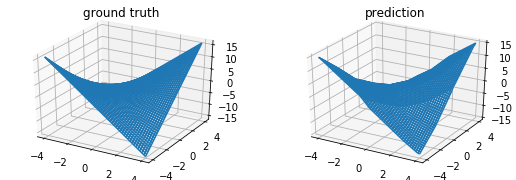

In [17]:
fig = plt.figure(figsize=(9,3))
a1 = fig.add_subplot(121, projection='3d')
a1.plot_wireframe(X,Y,Z.reshape(X.shape))
a1.set_title('ground truth')
a2 = fig.add_subplot(122, projection='3d')
a2.plot_wireframe(X,Y,Zp)
a2.set_title('prediction')
plt.show()

Hmmm, not bad. But how does $X\,Y$ come out of linear combinations of $X$ and $Y$? Granted, the neural network does have a `relu` non-linearity, but it's a very weak non linearity which is either the identity or 0 for every point, so it doesn't seem powerful enough, does it? Also, it seems that the neural net prediction is not as smooth at the original data. Let's plot the magnitude of the gradient:

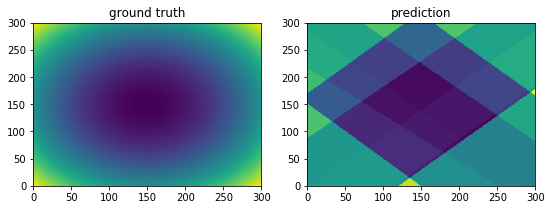

In [18]:
f,axs=plt.subplots(1,2,figsize=(9,3))
[ax.pcolormesh(np.sum([g**2 for g in np.gradient(ZZ)],axis=0)) for ax,ZZ in zip(axs,[Z,Zp])]
axs[0].set_title('ground truth')
axs[1].set_title('prediction');

To understand what's going on we'll consider first a 1D example:

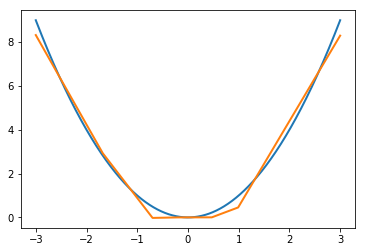

In [19]:
X_1d=np.linspace(-3,3,2000)
Z_1d=X_1d**2

# 1D model
model_1d=keras.Sequential([
    Dense(6,activation='relu',input_shape=[1]),
    Dense(1,use_bias=False)
    ])
model_1d.compile(optimizer='sgd',loss='mean_squared_error')
model_1d.fit(x=X_1d,y=Z_1d,epochs=25,verbose=0)
Zp_1d=model_1d.predict(X_1d)

plt.figure()
plt.plot(X_1d,Z_1d,linewidth=2)
plt.plot(X_1d,Zp_1d,linewidth=2)
plt.show()

We see that the prediction is piecewise-linear, which is not surprising given the functional form. It also explains how with enough neurons we could approximate any function we wanted. Let's look at the output of the hidden layer.

- In practical situations it is frequently seen that when a neural network can't learn the true feature of the mapping, it learns the mapping in a piecewise form.

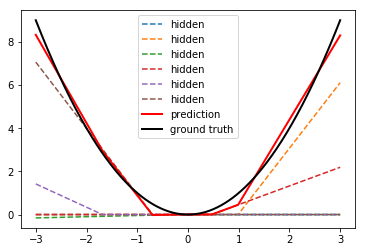

In [20]:
hidden = keras.Model(inputs=model_1d.input,
                     outputs=model_1d.layers[0].output)
hidden_output = hidden.predict(X_1d)

plt.figure()
plt.plot(X_1d,(hidden_output*model_1d.layers[1].get_weights()[0].T),'--',label='hidden')
plt.plot(X_1d,Zp_1d,'r',linewidth=2,label='prediction')
plt.plot(X_1d,Z_1d,'k',linewidth=2,label='ground truth')
plt.gca().legend()


We also see that even for this simple network the optimization algorithm somehow does not manage to fully use its expressive power, as some of the hidden neurons are basically flat. 

In 2D it's basically the same. Here we plot slices along constant $Y$:

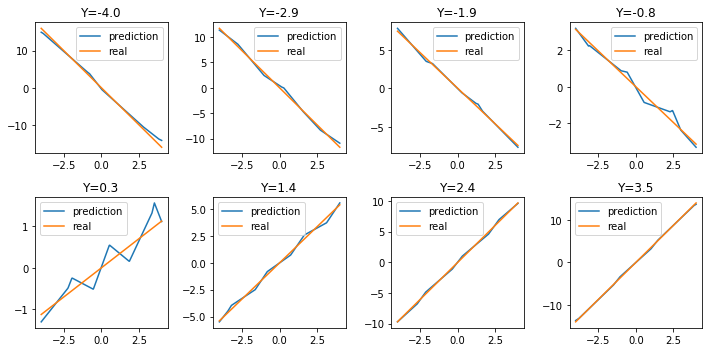

In [22]:
f,axs=plt.subplots(2,4,figsize=(10,5))
axs=axs.flatten()
for i,ax in zip(range(0,300,40),axs):
    ax.plot(X[i],Zp[i], label = 'prediction')
    ax.plot(X[i],Z[i], label = 'real')
    ax.set_title('Y=%1.1f'%Y[i,0])
    ax.legend()
f.tight_layout()

Unsurprisngly, it completely fails for input outside the training data:

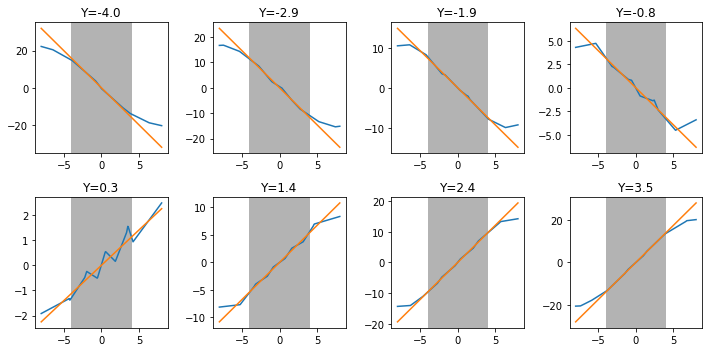

In [23]:
Xe,Ye=np.meshgrid(np.linspace(-8,8,300),np.linspace(-4,4,300))
XYe=np.array([Xe.flatten(),Ye.flatten()]).T
Ze=Xe*Ye
Zep=model.predict(XYe).reshape(Xe.shape)
f,axs=plt.subplots(2,4,figsize=(10,5))
axs=axs.flatten()
for i,ax in zip(range(0,300,40),axs):
    ax.plot(Xe[i],Zep[i])
    ax.plot(Xe[i],Ze[i])
    ax.set_title('Y=%1.1f'%Y[i,0])
    ax.axvspan(-4, 4, facecolor=[.7,.7,.7])#, alpha=0.1)
f.tight_layout()

**What's your impression from this example?**

# 1. CIFAR-10 - Keras

In the excersises below, we will model a classification task with the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset using [Keras](https://keras.io/).

We will start out with a simple solution and progressively improve upon it.

## 1.1 Loading the dataset

In [24]:
import numpy as np

from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Examining the dataset

In [25]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


We have 50000 training and 10000 test images in the dataset. The images have a structure of (32,32,3) which correspond to (width, height, RGB).

For each image there is a corresponding label, which is a class index.

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


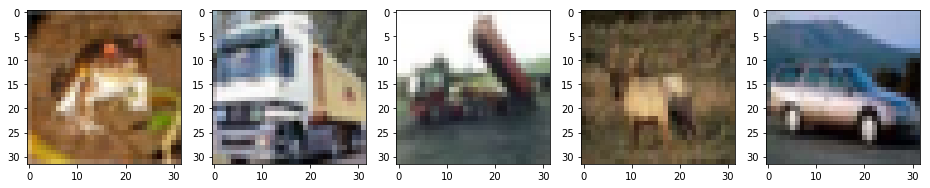

In [29]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

#### Preparing the dataset

First we are going to use a Multilayer Perceptron (Feed-forward sequential model) to classify our images. 

Instead of class indices we will use one-hot encoded vectors to represent the labels of the samples just like the MNIST case. Basically we use a 10-dimensional vector with the $i$th component being 1 to represent the $i$th class.


We also need to vectorize the images, since the MLP will take a 3072-dimensional vector as the input.
When working with images, a simple way to normalize our data is to fit it within the 0 to 1 range.

In [32]:
# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

X_train /= 255
X_test /= 255

## 1.2. MLP classifier

The MLPs are capable of modelling complex classification problems which are typically not linearly separable, as we have seen in lab 1.

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=3072))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Let's see how many parameters this model have

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


#### Training the MLP

Let's train our model now! We will store the training loss values and metrics in a history object, so we can visualize the training process later.

We are going to train the model for 15 epochs, using a batch size of 32 and a validation split of 0.2. The latter means that 20% of our training data will be used as validation samples (in practice however it is advised to separate the validation data from the training data altogether).  

In [34]:
history = model.fit(X_train,y_train, epochs=15, batch_size=32, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 7s - loss: 1.8360 - acc: 0.3345 - val_loss: 1.7344 - val_acc: 0.3815
Epoch 2/15
 - 7s - loss: 1.6711 - acc: 0.4014 - val_loss: 1.7453 - val_acc: 0.3818
Epoch 3/15
 - 7s - loss: 1.5956 - acc: 0.4310 - val_loss: 1.6007 - val_acc: 0.4247
Epoch 4/15
 - 7s - loss: 1.5487 - acc: 0.4466 - val_loss: 1.6309 - val_acc: 0.4171
Epoch 5/15
 - 7s - loss: 1.5158 - acc: 0.4533 - val_loss: 1.6027 - val_acc: 0.4281
Epoch 6/15
 - 7s - loss: 1.4901 - acc: 0.4647 - val_loss: 1.5449 - val_acc: 0.4531
Epoch 7/15
 - 7s - loss: 1.4657 - acc: 0.4753 - val_loss: 1.5497 - val_acc: 0.4552
Epoch 8/15
 - 7s - loss: 1.4431 - acc: 0.4830 - val_loss: 1.5481 - val_acc: 0.4515
Epoch 9/15
 - 7s - loss: 1.4237 - acc: 0.4886 - val_loss: 1.5881 - val_acc: 0.4521
Epoch 10/15
 - 6s - loss: 1.4046 - acc: 0.5005 - val_loss: 1.5575 - val_acc: 0.4637
Epoch 11/15
 - 6s - loss: 1.3877 - acc: 0.5059 - val_loss: 1.5373 - val_acc: 0.4637
Epoch 12/15
 - 7s - loss: 1.3767 - 

With this simple function we will be able to plot our training history.

In [36]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

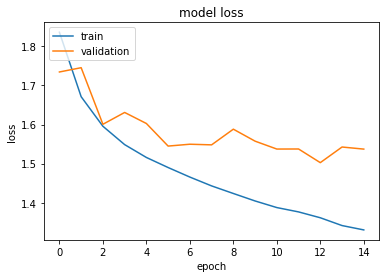

In [37]:
plotLosses(history)

Where does the overfitting start?

#### Evaluating the MLP

To get a measure of our model's performance we need to evaluate it using the test samples:

In [39]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [40]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[1.5136431945800781, 0.4728]


## 1.3. CNN classifier

So far, we have not exploited that we are working with images. By using [Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/), we can take advantage of the special structure of 
the inputs. Convolutions are [translation invariant](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-netral-netwo), and this makes them especially well suited for processing images.

#### Preparing the dataset

In [41]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [42]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 10)
Shape of test data:
(10000, 32, 32, 3)
(10000, 10)


#### Creating CNN model

We will use two convolutional layers, each with 32 filters a kernel size of (3,3) and ReLU activation function.

In [43]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               1605888   
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
Total params: 1,618,602
Trainable params: 1,618,602
Non-trainable params: 0
_________________________________________________________________


#### Training the CNN

In [45]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 49s - loss: 1.4823 - acc: 0.4699 - val_loss: 1.3167 - val_acc: 0.5326
Epoch 2/15
 - 45s - loss: 1.0637 - acc: 0.6252 - val_loss: 1.0115 - val_acc: 0.6502
Epoch 3/15
 - 45s - loss: 0.8447 - acc: 0.7029 - val_loss: 1.0046 - val_acc: 0.6530
Epoch 4/15
 - 47s - loss: 0.6414 - acc: 0.7751 - val_loss: 1.0405 - val_acc: 0.6666
Epoch 5/15
 - 49s - loss: 0.4521 - acc: 0.8404 - val_loss: 1.1344 - val_acc: 0.6669
Epoch 6/15
 - 48s - loss: 0.2974 - acc: 0.8961 - val_loss: 1.3534 - val_acc: 0.6593
Epoch 7/15
 - 48s - loss: 0.2122 - acc: 0.9255 - val_loss: 1.5233 - val_acc: 0.6580
Epoch 8/15
 - 48s - loss: 0.1593 - acc: 0.9460 - val_loss: 1.7480 - val_acc: 0.6554
Epoch 9/15
 - 49s - loss: 0.1372 - acc: 0.9533 - val_loss: 1.9279 - val_acc: 0.6558
Epoch 10/15


KeyboardInterrupt: 

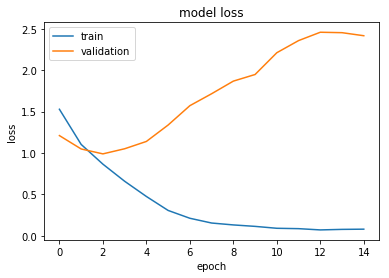

In [16]:
plotLosses(history)

Huge overfitting!

#### Evaluating the CNN

In [17]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [18]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[2.500901676940918, 0.6457]


As we can see, the CNN reached significantly higher accuracy than the MLP classifier, but overfitting occured during the training of our model. To avoid this, the use of some [regularization techniques](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/) would be advised. 

## 1.4. Regularization

In most cases, larger models have a tendency to overfit training data. While getting good performance on the training set, they will perform poorly on the test set. Regularization methods are used to prevent overfitting, making these larger models generalize better.

### 1.4.1 Dropout

[Dropout](https://arxiv.org/abs/1207.0580) works on a neural network layer by masking a random subset of its outputs (zeroing them) for every input with probability `p` and scaling up the rest of the outputs by `1/(1 - p)`.

[This link](https://www.python-course.eu/neural_networks_with_dropout.php) gives a perfect graphical explanation of dropout.

Dropout is normally used during training. Masking prevents gradient backpropagation through the masked outputs. The method thus selects a random subset of the neural network to train on any particular example. This can be thought of as training a model ensemble to solve the task, with the individual models sharing parameters.

At test time, `p` is set to zero. This can be interpreted as averaging the outputs of the ensemble models. Because of the scaling, the expected layer outputs are the same during training and testing.

In [19]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Dropout layer added here
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

#### Training the CNN which now contains dropout layers

In [20]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 13s - loss: 1.7196 - acc: 0.3707 - val_loss: 1.4212 - val_acc: 0.4857
Epoch 2/15
 - 11s - loss: 1.3874 - acc: 0.5000 - val_loss: 1.2307 - val_acc: 0.5568
Epoch 3/15
 - 11s - loss: 1.2296 - acc: 0.5615 - val_loss: 1.1826 - val_acc: 0.5888
Epoch 4/15
 - 11s - loss: 1.1268 - acc: 0.6029 - val_loss: 1.0526 - val_acc: 0.6353
Epoch 5/15
 - 11s - loss: 1.0476 - acc: 0.6274 - val_loss: 1.0252 - val_acc: 0.6423
Epoch 6/15
 - 11s - loss: 0.9697 - acc: 0.6617 - val_loss: 1.0035 - val_acc: 0.6500
Epoch 7/15
 - 11s - loss: 0.8979 - acc: 0.6815 - val_loss: 0.9850 - val_acc: 0.6560
Epoch 8/15
 - 11s - loss: 0.8476 - acc: 0.7010 - val_loss: 1.0023 - val_acc: 0.6490
Epoch 9/15
 - 11s - loss: 0.7937 - acc: 0.7180 - val_loss: 0.9915 - val_acc: 0.6653
Epoch 10/15
 - 11s - loss: 0.7459 - acc: 0.7340 - val_loss: 0.9725 - val_acc: 0.6742
Epoch 11/15
 - 11s - loss: 0.7105 - acc: 0.7481 - val_loss: 0.9770 - val_acc: 0.6744
Epoch 12/15
 - 11s - los

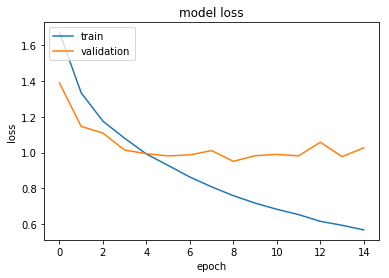

In [26]:
plotLosses(history)

### 1.4.2 Batch normalization

[Batch Normalization](https://arxiv.org/abs/1502.03167) works by normalizing layer outputs to a running mean and variance. This speeds up training and improves the final performance of the model. The running statistics are fixed at test time.

While batch normalization works as a regularizer, it also benefits smaller models.

In [21]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [22]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 16s - loss: 1.6012 - acc: 0.4324 - val_loss: 1.2655 - val_acc: 0.5333
Epoch 2/15
 - 15s - loss: 1.2542 - acc: 0.5550 - val_loss: 1.1303 - val_acc: 0.5969
Epoch 3/15
 - 14s - loss: 1.1074 - acc: 0.6073 - val_loss: 1.0324 - val_acc: 0.6322
Epoch 4/15
 - 14s - loss: 1.0025 - acc: 0.6449 - val_loss: 0.9621 - val_acc: 0.6626
Epoch 5/15
 - 14s - loss: 0.9354 - acc: 0.6711 - val_loss: 0.9224 - val_acc: 0.6717
Epoch 6/15
 - 15s - loss: 0.8808 - acc: 0.6875 - val_loss: 0.9085 - val_acc: 0.6829
Epoch 7/15
 - 14s - loss: 0.8300 - acc: 0.7024 - val_loss: 1.1020 - val_acc: 0.6225
Epoch 8/15
 - 14s - loss: 0.7796 - acc: 0.7234 - val_loss: 0.8956 - val_acc: 0.6890
Epoch 9/15
 - 14s - loss: 0.7440 - acc: 0.7349 - val_loss: 0.8996 - val_acc: 0.6907
Epoch 10/15
 - 14s - loss: 0.7102 - acc: 0.7470 - val_loss: 0.9567 - val_acc: 0.6760
Epoch 11/15
 - 15s - loss: 0.6813 - acc: 0.7577 - val_loss: 0.8423 - val_acc: 0.7081
Epoch 12/15
 - 14s - los

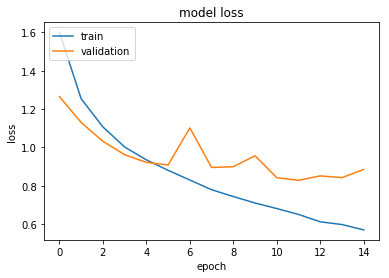

In [23]:
plotLosses(history)

#### Evaluating the CNN (with dropout and batch normalization)

In [24]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [25]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.9001454822540284, 0.6958]


### 1.4.3 Data Augmentation

In [45]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)   # flip images horizontally

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train[:40000], y_train[:40000], batch_size=32)
validation_generator = validation_datagen.flow(X_train[40000:], y_train[40000:], batch_size=32)

In [46]:
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

adam = Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [47]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator,    
                    validation_data=validation_generator,
                    validation_steps=len(X_train[40000:]) / 32,
                    steps_per_epoch=len(X_train[:40000]) / 32,
                    epochs=15,
                    verbose=2)

Epoch 1/15
 - 22s - loss: 1.6077 - acc: 0.4339 - val_loss: 1.3149 - val_acc: 0.5389
Epoch 2/15
 - 22s - loss: 1.2702 - acc: 0.5459 - val_loss: 1.0530 - val_acc: 0.6322
Epoch 3/15
 - 22s - loss: 1.1561 - acc: 0.5896 - val_loss: 0.9933 - val_acc: 0.6535
Epoch 4/15
 - 21s - loss: 1.1022 - acc: 0.6102 - val_loss: 1.1616 - val_acc: 0.6080
Epoch 5/15
 - 21s - loss: 1.0641 - acc: 0.6221 - val_loss: 1.0029 - val_acc: 0.6513
Epoch 6/15
 - 21s - loss: 1.0402 - acc: 0.6350 - val_loss: 0.8972 - val_acc: 0.6834
Epoch 7/15
 - 21s - loss: 1.0110 - acc: 0.6468 - val_loss: 0.8085 - val_acc: 0.7182
Epoch 8/15
 - 21s - loss: 0.9917 - acc: 0.6510 - val_loss: 0.9505 - val_acc: 0.6710
Epoch 9/15
 - 21s - loss: 0.9638 - acc: 0.6640 - val_loss: 0.8966 - val_acc: 0.6890
Epoch 10/15
 - 21s - loss: 0.9430 - acc: 0.6699 - val_loss: 0.9033 - val_acc: 0.6828
Epoch 11/15
 - 21s - loss: 0.9389 - acc: 0.6711 - val_loss: 0.8320 - val_acc: 0.7082
Epoch 12/15
 - 21s - loss: 0.9242 - acc: 0.6745 - val_loss: 1.1632 - val_a

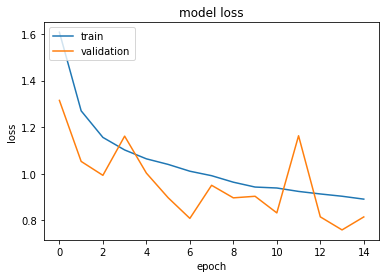

In [48]:
plotLosses(history)

#### Evaluating the CNN (with dropout, batch normalization and data augmentation)

In [49]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [50]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.82181376247406, 0.7154]


# 2. CNN and Transfer learning on MNIST

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In order to save running time I have made the filter number and and filter size small. Code from Keras github https://github.com/keras-team/keras/blob/master/examples/mnist_transfer_cnn.py

In [26]:

'''Transfer learning toy example.
1 - Train a simple convnet on the MNIST dataset the first 5 digits [0..4].
2 - Freeze convolutional layers and fine-tune dense layers
   for the classification of digits [5..9].
Get to 99.8% test accuracy after 5 epochs using 32 filters
for the first five digits classifier
and 99.2% for the last five digits after transfer + fine-tuning.
'''

from __future__ import print_function

import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

now = datetime.datetime.now

batch_size = 128
num_classes = 5
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 8
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)


def train_model(model, train, test, num_classes):
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# create two datasets one with digits below 5 and one with 5 and above
x_train_lt5 = x_train[y_train < 5]
y_train_lt5 = y_train[y_train < 5]
x_test_lt5 = x_test[y_test < 5]
y_test_lt5 = y_test[y_test < 5]

x_train_gte5 = x_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5
x_test_gte5 = x_test[y_test >= 5]
y_test_gte5 = y_test[y_test >= 5] - 5

# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

# create complete model
model = Sequential(feature_layers + classification_layers)

# train model for 5-digit classification [0..4]
train_model(model,
            (x_train_lt5, y_train_lt5),
            (x_test_lt5, y_test_lt5), num_classes)

# freeze feature layers and rebuild model
for l in feature_layers:
    l.trainable = False

# transfer: train dense layers for new classification task [5..9]
train_model(model,
            (x_train_gte5, y_train_gte5),
            (x_test_gte5, y_test_gte5), num_classes)

x_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples
Train on 30596 samples, validate on 5139 samples
Epoch 1/5
30596/30596 [==============================] - 7s 227us/step - loss: 0.2123 - acc: 0.9307 - val_loss: 0.0391 - val_acc: 0.9872
Epoch 2/5
30596/30596 [==============================] - 6s 206us/step - loss: 0.0695 - acc: 0.9794 - val_loss: 0.0214 - val_acc: 0.9924
Epoch 3/5
30596/30596 [==============================] - 6s 199us/step - loss: 0.0515 - acc: 0.9846 - val_loss: 0.0186 - val_acc: 0.9936
Epoch 4/5
30596/30596 [==============================] - 6s 194us/step - loss: 0.0405 - acc: 0.9873 - val_loss: 0.0145 - val_acc: 0.9946
Epoch 5/5
30596/30596 [==============================] - 6s 197us/step - loss: 0.0351 - acc: 0.9901 - val_loss: 0.0124 - val_acc: 0.9959
Training time: 0:00:31.938241
Test score: 0.012438353931364672
Test accuracy: 0.9959136018680678
x_train shape: (29404, 28, 28, 1)
29404 train samples
4861 test samples
Train on 29404 samples, v

### See what the filters look like
Below is the first layer of filters. These filters contain such low-level information (i.e., not figure-specific) that can naturally thought to be able to transfer.

In [29]:
conv_filters1 = model.get_weights()[0]
conv_filters1 = np.transpose(conv_filters1, axes = [3,2,1,0]).reshape(filters, kernel_size, kernel_size)

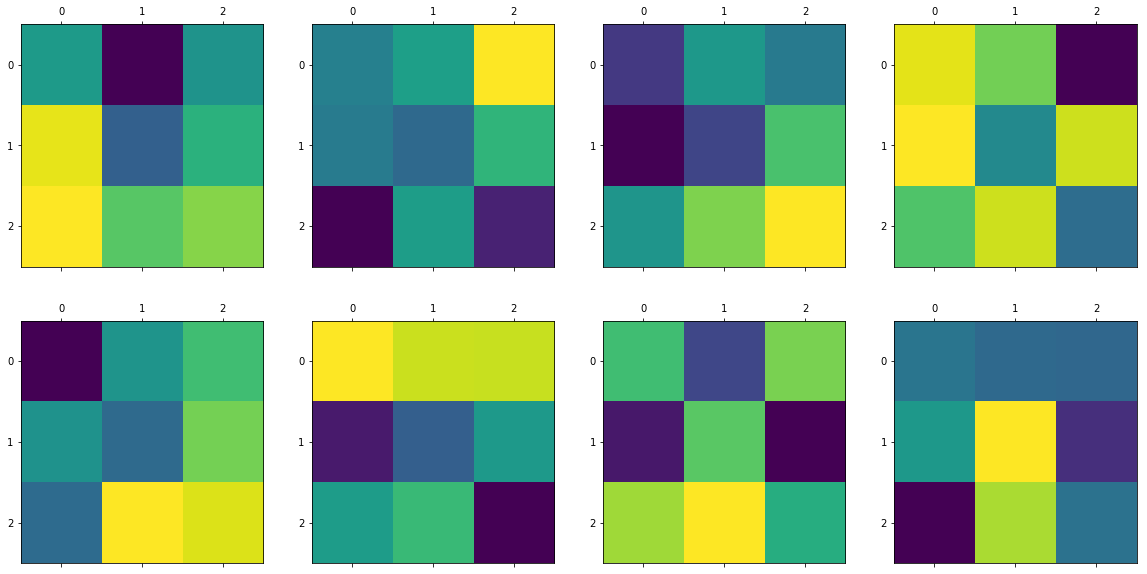

In [31]:
fig, ax = plt.subplots(2,4, figsize = (20,10))
for i in range(8):
    ax[i//4, i%4].matshow(conv_filters1[i])

# 3*(Not required for this time). Transfer learning using Tensorflow hub

In [38]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

In [42]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 16s 0us/step


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

The image size will be handles later.

In [43]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [44]:
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


## Simple transfer learning

Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector) will work here.

In [45]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

In [46]:
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size:

In [47]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Wrap the module in a keras layer.

In [48]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [49]:
features_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [50]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


When using Keras, TFHub modules need to be manually initialized.

In [53]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

Test run a single batch, to see that the result comes back with the expected shape.

In [54]:
result = model.predict(image_batch)
result.shape

(32, 5)

### Train the model

Use compile to configure the training process:

In [55]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch. 

In [56]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [57]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/1
114/114 [==============================] - 86s 751ms/step - loss: 0.6540 - acc: 0.7668


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

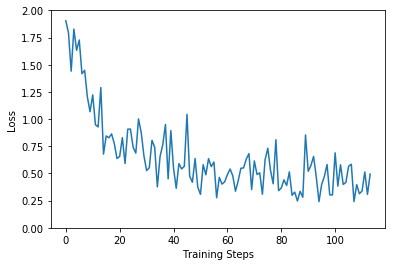

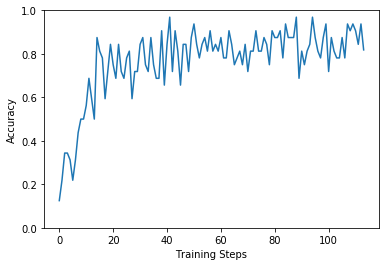

In [58]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [59]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and comvert the indices to class names.

In [60]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Tulips', 'Daisy', 'Dandelion', 'Tulips', 'Dandelion', 'Tulips',
       'Tulips', 'Tulips', 'Tulips', 'Tulips', 'Sunflowers', 'Dandelion',
       'Sunflowers', 'Roses', 'Tulips', 'Tulips', 'Dandelion', 'Roses',
       'Sunflowers', 'Daisy', 'Dandelion', 'Daisy', 'Tulips', 'Tulips',
       'Sunflowers', 'Daisy', 'Sunflowers', 'Dandelion', 'Dandelion',
       'Tulips', 'Sunflowers', 'Sunflowers'], dtype='<U10')

Plot the result

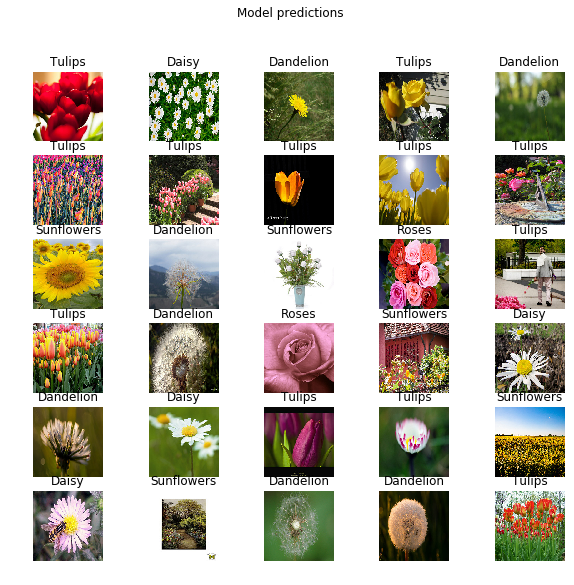

In [61]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a saved model:

In [0]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).



In [ ]:
# 3. Transfer learning using Tensorflow hub

from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

The image size will be handles later.

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

## Simple transfer learning

Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector) will work here.

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size:

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Wrap the module in a keras layer.

features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

features_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

When using Keras, TFHub modules need to be manually initialized.

import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

Test run a single batch, to see that the result comes back with the expected shape.

result = model.predict(image_batch)
result.shape

### Train the model

Use compile to configure the training process:

model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch. 

class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


### Check the predictions

To redo the plot from before, first get the ordered list of class names:

label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

Run the image batch through the model and comvert the indices to class names.

result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

Plot the result

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a saved model:

export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

